In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




The code will run on GPU.


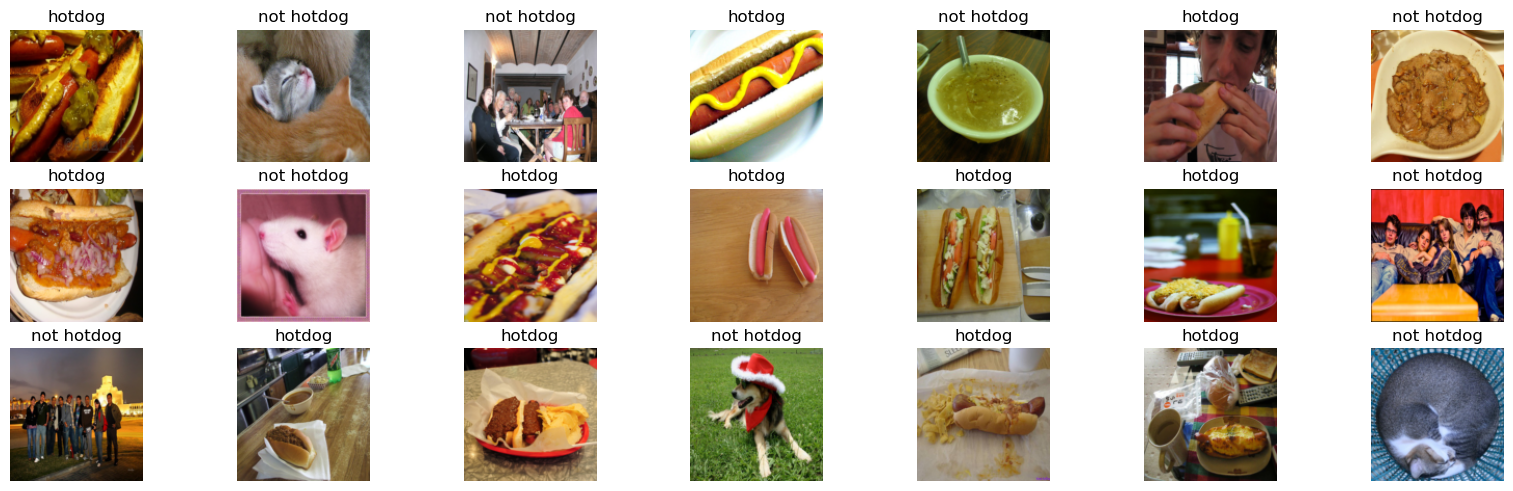

In [2]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y
    
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

In [20]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2),
                nn.Dropout(0.25),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(128*128*8, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        
        return x
    


In [21]:
settings = [
    ("Adam_lr=0.0001", torch.optim.Adam, {'lr': 0.0001}),
    ("SGD_lr=0.01_momentum=0.5", torch.optim.SGD, {'lr': 0.01, 'momentum': 0.5}),
    ("SGD_lr=0.001_momentum=0.5", torch.optim.SGD, {'lr': 0.001, 'momentum': 0.5})
]

In [22]:
def train_cross(model, optimizer, num_epochs=10, scheduler=None):
    def loss_fun(output, target):
        return nn.CrossEntropyLoss()(output, target)

    test_accuracies = []
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        train_correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fun(output, target)
            loss.backward()
            optimizer.step()

            predicted = output.argmax(1)
            train_correct += (target == predicted).sum().cpu().item()
        
        # Evaluate test accuracy
        model.eval()
        test_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                predicted = output.argmax(1)
                test_correct += (target == predicted).sum().cpu().item()

        test_accuracy = test_correct / len(test_loader.dataset)
        test_accuracies.append(test_accuracy * 100)
        
        if scheduler:
            scheduler.step()
            
    return test_accuracies

In [14]:
def evaluate_worst_predictions(model, test_loader, criterion):
    model.eval()
    worst_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Output should be of shape (batch_size, 2)
            probabilities = F.softmax(output, dim=1)[:, 1]  # Extract probability of the 'hotdog' class
            predictions = output.argmax(dim=1)  # Get class predictions (0 or 1)

            # Find incorrect predictions
            incorrect_indices = (predictions != target).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                prob = probabilities[idx].item()
                true_label = target[idx].item()
                worst_predictions.append((prob, data[idx].cpu(), true_label, predictions[idx].item()))

    # Sort by the most confident wrong predictions
    worst_predictions.sort(key=lambda x: abs(x[0] - 0.5), reverse=True)
    
    return worst_predictions[:3]  # Return the top 3 worst predictions


def plot_worst_predictions(worst_predictions, optimizer_label):
    plt.figure(figsize=(15, 5))
    
    for i, (conf, img, true_label, pred_label) in enumerate(worst_predictions):
        plt.subplot(1, 3, i + 1)
        img = img.permute(1, 2, 0)  # Rearrange to HWC
        plt.imshow(img)
        plt.title(f"True: {'Hotdog' if true_label else 'Not Hotdog'}\n"
                  f"Pred: {'Hotdog' if pred_label else 'Not Hotdog'}\nConf: {conf:.2f}")
        plt.axis('off')
    
    plt.suptitle(f"Worst Predictions using {optimizer_label}")
    plt.tight_layout()
    plt.show()

In [23]:
results = {}

# Training with different optimization settings
for label, optimizer_class, optimizer_params in settings:
    model = Network().to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    test_accuracies = train_cross(model, optimizer, num_epochs=10)
    results[label] = test_accuracies
    # worst_predictions = evaluate_worst_predictions(model, test_loader, criterion=nn.BCEWithLogitsLoss())
    # plot_worst_predictions(worst_predictions, label)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

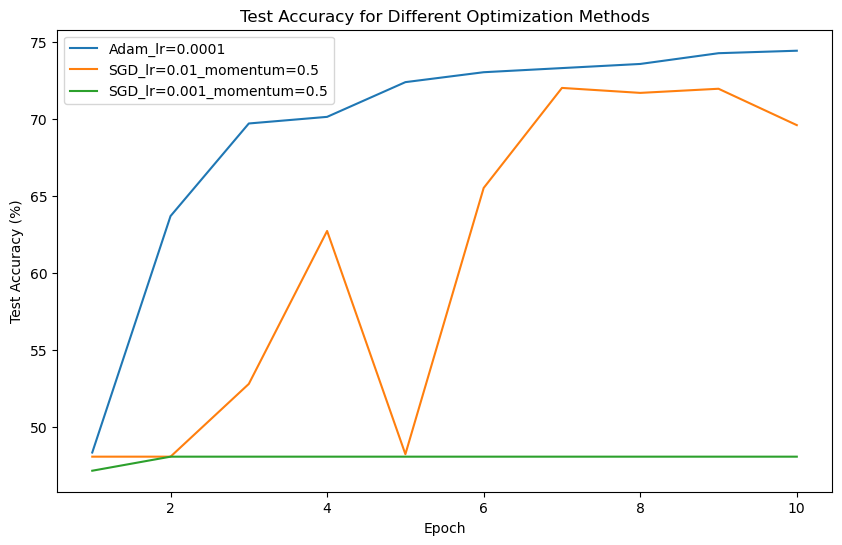

In [24]:
# Plotting the results
plt.figure(figsize=(10, 6))
for label, accuracies in results.items():
    plt.plot(range(1, 11), accuracies, label=label)

plt.title("Test Accuracy for Different Optimization Methods")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.show()

In [25]:
def train(model, optimizer, num_epochs=10, scheduler=None):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)

    test_accuracies = []
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        train_correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fun(output, target)
            loss.backward()
            optimizer.step()

            predicted = output.argmax(1)
            train_correct += (target == predicted).sum().cpu().item()
        
        # Evaluate test accuracy
        model.eval()
        test_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                predicted = output.argmax(1)
                test_correct += (target == predicted).sum().cpu().item()

        test_accuracy = test_correct / len(test_loader.dataset)
        test_accuracies.append(test_accuracy * 100)
        
        if scheduler:
            scheduler.step()
            
    return test_accuracies

In [26]:
results = {}

# Training with different optimization settings
for label, optimizer_class, optimizer_params in settings:
    model = Network().to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    test_accuracies = train(model, optimizer, num_epochs=10)
    results[label] = test_accuracies

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

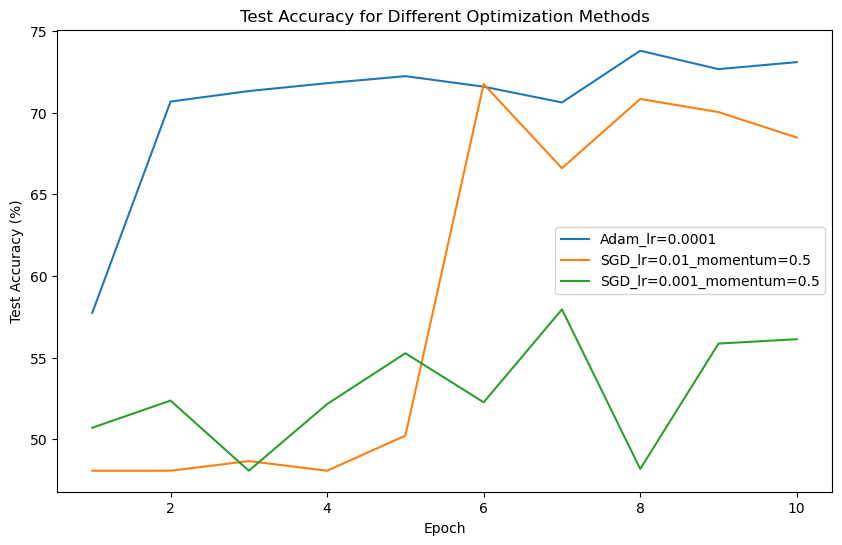

In [27]:
# Plotting the results
plt.figure(figsize=(10, 6))
for label, accuracies in results.items():
    plt.plot(range(1, 11), accuracies, label=label)

plt.title("Test Accuracy for Different Optimization Methods")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.show()